In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from churn_measurements import calibration, discrimination
from scipy.stats import mstats
import bisect
from scipy import interp
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pylab as plt
import numpy as np
from IPython import get_ipython


In [2]:
# File Name: Churn_Fun.ipynb



In [3]:
# load modules

import pandas as pd
pd.set_option('precision', 3)
get_ipython().run_line_magic('matplotlib', 'inline')
# pretty print only the last output of the cell
InteractiveShell.ast_node_interactivity = "last_expr"
warnings.filterwarnings('ignore')
# Load in the r magic
get_ipython().run_line_magic('load_ext', 'rpy2.ipython')
# We need ggplot2
get_ipython().run_line_magic('R', 'require(ggplot2)')
# local modules



R[write to console]: Loading required package: ggplot2



array([1], dtype=int32)

In [4]:
print("~ Importing Data ~")
df = pd.read_csv("data\\churn.csv")



~ Importing Data ~


In [5]:
print("~ Preprocessing Data ~")
col_names = df.columns.tolist()
print("Column names:")
print(col_names)



~ Preprocessing Data ~
Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [6]:
to_show = col_names[:6] + col_names[-6:]
print('\n Sample data:')
df[to_show].head(6)




 Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [7]:
print(df.shape)
print(df.dtypes)



(3333, 21)
State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object


In [8]:
# The number of numeric data
len(df.select_dtypes(include=['int64', 'float64']).columns)



16

In [9]:
# The number of categorical data
len(df.select_dtypes(include=['category', 'object']).columns)



5

In [10]:
# Check there is any missing data
for i in df.columns.tolist():
    k = sum(pd.isnull(df[i]))
    print((i, k))



('State', 0)
('Account Length', 0)
('Area Code', 0)
('Phone', 0)
("Int'l Plan", 0)
('VMail Plan', 0)
('VMail Message', 0)
('Day Mins', 0)
('Day Calls', 0)
('Day Charge', 0)
('Eve Mins', 0)
('Eve Calls', 0)
('Eve Charge', 0)
('Night Mins', 0)
('Night Calls', 0)
('Night Charge', 0)
('Intl Mins', 0)
('Intl Calls', 0)
('Intl Charge', 0)
('CustServ Calls', 0)
('Churn?', 0)


In [11]:
print("~ Exploring Data ~")
# numeric data
# print df.describe()
# same as above
print(df.describe(include=['int64', 'float64']))



~ Exploring Data ~
       Account Length  Area Code  VMail Message  Day Mins  Day Calls  \
count        3333.000   3333.000       3333.000  3333.000   3333.000   
mean          101.065    437.182          8.099   179.775    100.436   
std            39.822     42.371         13.688    54.467     20.069   
min             1.000    408.000          0.000     0.000      0.000   
25%            74.000    408.000          0.000   143.700     87.000   
50%           101.000    415.000          0.000   179.400    101.000   
75%           127.000    510.000         20.000   216.400    114.000   
max           243.000    510.000         51.000   350.800    165.000   

       Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  Night Calls  \
count    3333.000  3333.000   3333.000    3333.000    3333.000     3333.000   
mean       30.562   200.980    100.114      17.084     200.872      100.108   
std         9.259    50.714     19.923       4.311      50.574       19.569   
min         0.00

In [12]:
# categorical and object data
print(df.describe(include=['category', 'object']))



State     Phone Int'l Plan VMail Plan  Churn?
count   3333      3333       3333       3333    3333
unique    51      3333          2          2       2
top       WV  366-2622         no         no  False.
freq     106         1       3010       2411    2850


In [13]:
print(df['Churn?'].value_counts())



False.    2850
True.      483
Name: Churn?, dtype: int64


In [14]:
print(df.groupby(df['Churn?']).mean())



Account Length  Area Code  VMail Message  Day Mins  Day Calls  \
Churn?                                                                  
False.         100.794    437.075          8.605   175.176    100.283   
True.          102.665    437.818          5.116   206.914    101.335   

        Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  Night Calls  \
Churn?                                                                         
False.      29.780   199.043    100.039      16.919     200.133      100.058   
True.       35.176   212.410    100.561      18.055     205.232      100.400   

        Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  
Churn?                                                                    
False.         9.006     10.159       4.533        2.743            1.45  
True.          9.236     10.700       4.164        2.890            2.23  


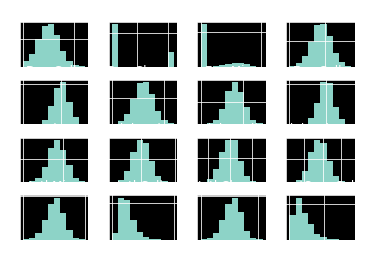

In [15]:
# Histogram
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()



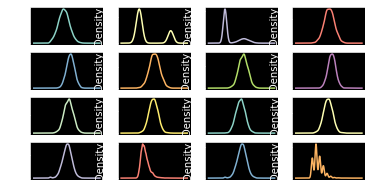

In [16]:
df.plot(kind='density', subplots=True, layout=(5, 4), sharex=False,
        legend=False, fontsize=1)
plt.show()



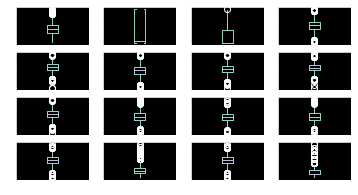

In [17]:
# Boxplots
df.plot(kind='box', subplots=True, layout=(5, 4), sharex=False,
        sharey=False, fontsize=1)
plt.show()



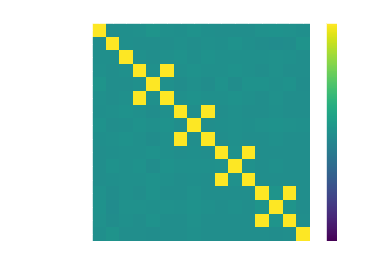

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0, len(df._get_numeric_data().columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df._get_numeric_data().columns.tolist())
ax.set_yticklabels(df._get_numeric_data().columns.tolist())
plt.show()



In [19]:
print("~ Preparing Target and Features Data ~")

# Isolate target data
y = np.where(df['Churn?'] == 'True.', 1, 0)

# We don't need these columns
to_drop = ['State', 'Area Code', 'Phone', 'Churn?']
df = df.drop(to_drop, axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
# yes_no_cols will be re-used for later scoring
yes_no_cols = ["Int'l Plan", "VMail Plan"]
df[yes_no_cols] = df[yes_no_cols] == 'yes'

# Pull out fesatures for later scoring
features = df.columns

# feature variables
X = df.to_numpy().astype(np.float)



~ Preparing Target and Features Data ~


Feature ranking:
1. Account Length (0.141589)
2. Int'l Plan (0.133900)
3. VMail Plan (0.072053)
4. VMail Message (0.066800)
5. Day Mins (0.066007)
6. Day Calls (0.034031)
7. Day Charge (0.031002)
8. Eve Mins (0.030832)
9. Eve Calls (0.028906)
10. Eve Charge (0.023389)


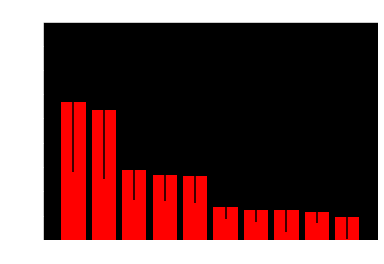

In [20]:
# Importances of features
train_index, test_index = train_test_split(df.index, random_state=4)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])


importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print(("%d. %s (%f)" % (f + 1, df.columns[f], importances[indices[f]])))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(list(range(10)), importances[indices],
        yerr=std[indices], color="r", align="center")
plt.xticks(list(range(10)), indices)
plt.xlim([-1, 10])
plt.show()



In [21]:
print("~ Transforming Data ~")
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))



~ Transforming Data ~
Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [22]:
print("~ Building K-Fold Cross-Validations ~")


def run_cv(X, y, clf):
    # construct a K-Fold object
    kf = KFold(n_splits=5, shuffle=True, random_state=4)
    y_pred = y.copy()

    # iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred



~ Building K-Fold Cross-Validations ~


In [23]:
print("~ Evaluating Models ~")


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


print("Logistic Regression:")
print("Accuracy = %.3f" % accuracy(y, run_cv(X, y, LR())))
print("Gradient Boosting Classifier:")
print("Accuracy = %.3f" % accuracy(y, run_cv(X, y, GBC())))
print("Support vector machines:")
print("Accuracy = %.3f" % accuracy(y, run_cv(X, y, SVC())))
print("Random forest:")
print("Accuracy = %.3f" % accuracy(y, run_cv(X, y, RF())))
print("K-nearest-neighbors:")
print("Accuracy = %.3f" % accuracy(y, run_cv(X, y, KNN())))



~ Evaluating Models ~
Logistic Regression:
Accuracy = 0.860
Gradient Boosting Classifier:
Accuracy = 0.952
Support vector machines:
Accuracy = 0.920
Random forest:
Accuracy = 0.950
K-nearest-neighbors:
Accuracy = 0.893


Logisitic Regression F1 Score 0.3019431988041853
Gradient Boosting Classifier F1 Score 0.8151549942594718
Support Vector Machines F1 Score 0.6517739816031537
Random Forest F1 Score 0.8130081300813008
K-Nearest-Neighbors F1 Score 0.49002849002849


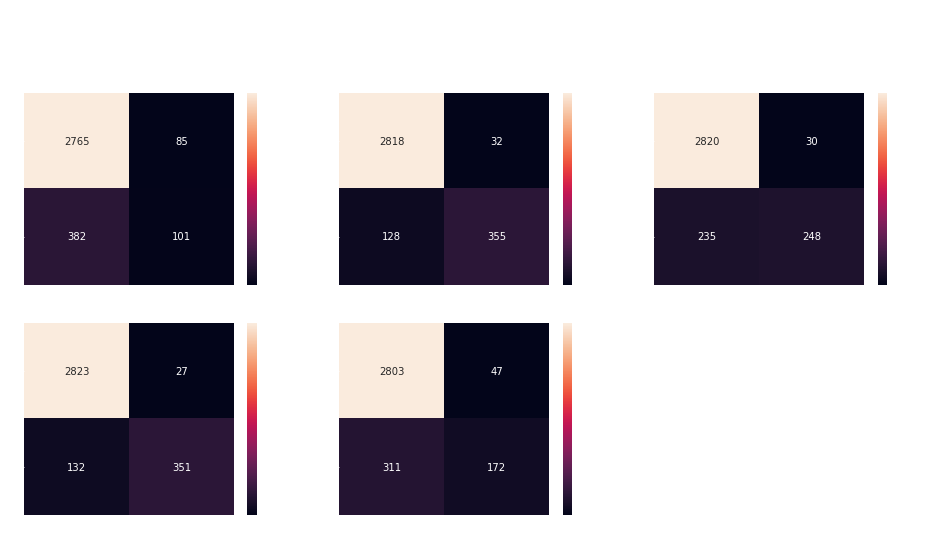

In [24]:
# F1-Scores and Confusion Matrices
def draw_confusion_matrices(confusion_matricies, class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


y = np.array(y)
class_names = np.unique(y)


confusion_matrices = {
    1: {
        'matrix': confusion_matrix(y, run_cv(X, y, LR())),
        'title': 'Logistic Regression',
    },
    2: {
        'matrix': confusion_matrix(y, run_cv(X, y, GBC())),
        'title': 'Gradient Boosting Classifier',
    },
    3: {
        'matrix': confusion_matrix(y, run_cv(X, y, SVC())),
        'title': 'Support Vector Machine',
    },
    4: {
        'matrix': confusion_matrix(y, run_cv(X, y, RF())),
        'title': 'Random Forest',
    },
    5: {
        'matrix': confusion_matrix(y, run_cv(X, y, KNN())),
        'title': 'K Nearest Neighbors',
    },
}


fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in list(confusion_matrices.items()):
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 3, ii)  # starts from 1
    plt.title(title)
    sns.heatmap(matrix, annot=True,  fmt='')

print("Logisitic Regression F1 Score", f1_score(y, run_cv(X, y, LR())))
print("Gradient Boosting Classifier F1 Score",
      f1_score(y, run_cv(X, y, GBC())))
print("Support Vector Machines F1 Score", f1_score(y, run_cv(X, y, SVC())))
print("Random Forest F1 Score", f1_score(y, run_cv(X, y, RF())))
print("K-Nearest-Neighbors F1 Score", f1_score(y, run_cv(X, y, KNN())))



Logisitic Regression:


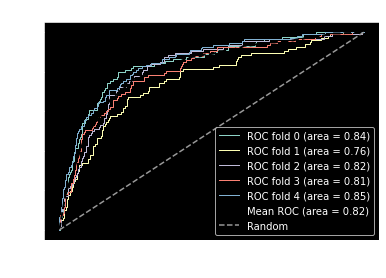

Gradient Boosting Classifier:


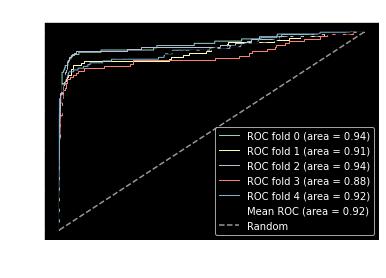

Support vector machines:


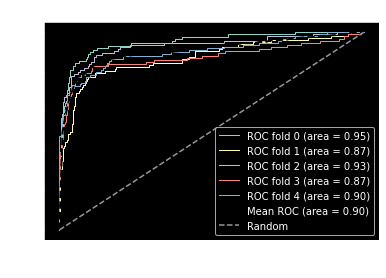

Random forests:


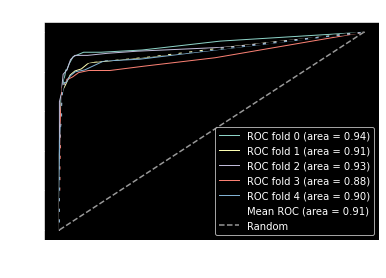

K-nearest-neighbors:


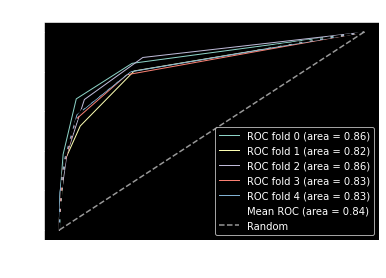

In [25]:
# ROC plots
def plot_roc(X, y, clf_class):
    kf = KFold(n_splits=5, shuffle=True, random_state=4)
    y_prob = np.zeros((len(y), 2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
#    all_tpr = []
    i = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class
        clf.fit(X_train, y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' %
                 (i, roc_auc))
        i = i + 1
    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


print("Logisitic Regression:")
plot_roc(X, y, LR())

print("Gradient Boosting Classifier:")
plot_roc(X, y, GBC())

print("Support vector machines:")
plot_roc(X, y, SVC(probability=True))

print("Random forests:")
plot_roc(X, y, RF(n_estimators=18))

print("K-nearest-neighbors:")
plot_roc(X, y, KNN())



In [26]:
print("~ Building K-Fold Cross-Validations with Probabilities ~")


def run_prob_cv(X, y, clf):
    kf = KFold(n_splits=5, shuffle=True, random_state=4)
    y_prob = np.zeros((len(y), 2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train, y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob



~ Building K-Fold Cross-Validations with Probabilities ~


In [27]:
print("~ Calculating Calibration and Discrimination ~")
# Take on RF
pred_prob = run_prob_cv(X, y, RF(n_estimators=10, random_state=4))

# Use 10 estimators so predictions are all multiples of 0.1
pred_churn = pred_prob[:, 1].round(1)
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]



~ Calculating Calibration and Discrimination ~


0.0    1698
0.1     758
0.2     272
0.3     123
0.8      78
0.6      78
0.4      76
0.7      72
0.9      66
0.5      62
1.0      50
dtype: int64

In [28]:
# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

counts = pd.concat([counts, true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts.sort_values('pred_prob').reset_index().drop(['index'], axis=1)



,pred_prob,count,true_prob
0,0.0,1698,0.026
1,0.1,758,0.024
2,0.2,272,0.085
3,0.3,123,0.195
4,0.4,76,0.276
5,0.5,62,0.581
6,0.6,78,0.808
7,0.7,72,0.889
8,0.8,78,0.962
9,0.9,66,0.985


In [29]:
baseline = np.mean(is_churn)



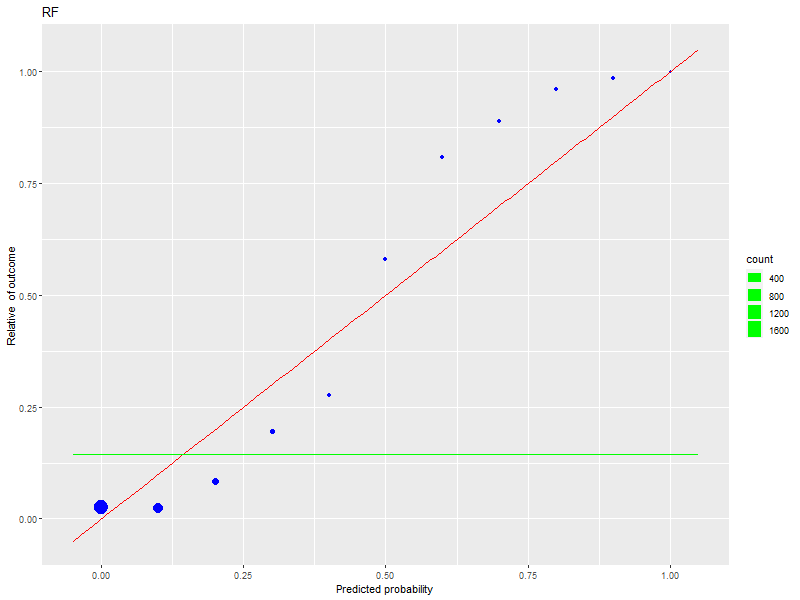

In [30]:
get_ipython().run_cell_magic('R', '-i counts,baseline -w 800 -h 600 -u px',
                             '\nggplot(counts,aes(x=pred_prob,y=true_prob,size=count)) + \n    geom_point(color=\'blue\') + \n    stat_function(fun = function(x){x}, color=\'red\') + \n    stat_function(fun = function(x){baseline}, color=\'green\') + \n    xlim(-0.05,  1.05) + ylim(-0.05,1.05) + \n    ggtitle("RF") + \n    xlab("Predicted probability") + ylab("Relative  of outcome")')



In [31]:
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:, 1], y == 1
    print("  %-20s %.4f" %
          ("Calibration Error", calibration(churn_prob, is_churn)))
    print("  %-20s %.4f" %
          ("Discrimination", discrimination(churn_prob, is_churn)))



In [32]:
print("Note -- Lower calibration is better, higher discrimination is better")
print("Logistic Regression:")
print_measurements(run_prob_cv(X, y, LR()))

print("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X, y, GBC()))

print("Support vector machines:")
print_measurements(run_prob_cv(X, y, SVC(probability=True)))

print("Random forests:")
print_measurements(run_prob_cv(X, y, RF(n_estimators=18)))

print("K-nearest-neighbors:")
print_measurements(run_prob_cv(X, y, KNN()))



Note -- Lower calibration is better, higher discrimination is better
Logistic Regression:
  Calibration Error    0.0014
  Discrimination       0.0249
Gradient Boosting Classifier:
  Calibration Error    0.0019
  Discrimination       0.0845
Support vector machines:
  Calibration Error    0.0009
  Discrimination       0.0660
Random forests:
  Calibration Error    0.0075
  Discrimination       0.0850
K-nearest-neighbors:
  Calibration Error    0.0020
  Discrimination       0.0428


In [33]:
print('~ Profit Curves ~')


def confusion_rates(cm):

    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]

    N = fp + tn
    P = tp + fn

    tpr = tp / P
    fpr = fp / P
    fnr = fn / N
    tnr = tn / N

    rates = np.array([[tpr, fpr], [fnr, tnr]])

    return rates


def profit_curve(classifiers):
    for clf_class in classifiers:
        name, clf_class = clf_class[0], clf_class[1]
        clf = clf_class
        fit = clf.fit(X[train_index], y[train_index])
        probabilities = np.array([prob[0]
                                  for prob in fit.predict_proba(X[test_index])])
        profit = []

        indicies = np.argsort(probabilities)[::1]

        for idx in range(len(indicies)):
            pred_true = indicies[:idx]
            ctr = np.arange(indicies.shape[0])
            masked_prediction = np.in1d(ctr, pred_true)
            cm = confusion_matrix(y_test.astype(
                int), masked_prediction.astype(int))
            rates = confusion_rates(cm)

            profit.append(np.sum(np.multiply(rates, cb)))

        plt.plot((np.arange(len(indicies)) / len(indicies) * 100),
                 profit, label=name)
    plt.legend(loc="lower right")
    plt.title("Profits of classifiers")
    plt.xlabel("Percentage of test instances (decreasing by score)")
    plt.ylabel("Profit")
    plt.show()



~ Profit Curves ~


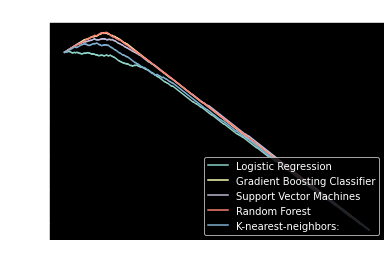

In [34]:
y_test = y[test_index].astype(float)

# Cost-Benefit Matrix
cb = np.array([[4, -5],
               [0, 0]])

# Define classifiers for comparison
classifiers = [("Logistic Regression", LR()),
               ("Gradient Boosting Classifier", GBC()),
               ("Support Vector Machines", SVC(probability=True)),
               ("Random Forest", RF(n_estimators=18)),
               ("K-nearest-neighbors:", KNN())
               ]

# Plot profit curves
profit_curve(classifiers)



In [35]:
forest = RF(n_estimators=18, random_state=4)
forest_fit = forest.fit(X[train_index], y[train_index])
predictions = forest_fit.predict(X[test_index])

print(confusion_matrix(y[test_index], predictions))
print(accuracy_score(y[test_index], predictions))
print(classification_report(y[test_index], predictions))



[[706   9]
 [ 24  95]]
0.960431654676259
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       715
           1       0.91      0.80      0.85       119

    accuracy                           0.96       834
   macro avg       0.94      0.89      0.91       834
weighted avg       0.96      0.96      0.96       834



In [36]:
# Grid Search and Hyper Parameters
rfc = RF(n_jobs=-1, max_features='sqrt',
         n_estimators=50, oob_score=True, random_state=4)

param_grid = {
    'n_estimators': [5, 10, 20, 40, 80, 160, 200],
    # 'min_samples_leaf': [1, 5, 10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X[train_index], y[train_index])

means = CV_rfc.cv_results_['mean_test_score']
stds = CV_rfc.cv_results_['std_test_score']

print(("Best: %f using %s with %s" %
       (CV_rfc.best_score_, CV_rfc.best_params_, CV_rfc.best_estimator_)))
for params, mean_score, scores in zip(CV_rfc.cv_results_['params'], means, stds):
    print(("%f (%f) with: %r" % (scores.mean(), scores.std(), params)))



Best: 0.949181 using {'max_features': 'auto', 'n_estimators': 200} with RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=4)
0.010604 (0.000000) with: {'max_features': 'auto', 'n_estimators': 5}
0.008457 (0.000000) with: {'max_features': 'auto', 'n_estimators': 10}
0.004269 (0.000000) with: {'max_features': 'auto', 'n_estimators': 20}
0.002704 (0.000000) with: {'max_features': 'auto', 'n_estimators': 40}
0.003695 (0.000000) with: {'max_features': 'auto', 'n_estimators': 80}
0.005106 (0.000000) with: {'max_features': 'auto', 'n_estimators': 160}
0.006392 (0.000000) with: {'max_features': 'auto', 'n_estimators': 200}
0.010604 (0.000000) with: {'max_features': 'sqrt', 'n_estimators': 5}
0.008457 (0.000000) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.004269 (0.000000) with: {'max_features': 'sqrt', 'n_estimators': 20}
0.002704 (0.000000) with: {'max_features': 'sqrt', 'n_estimators': 40}
0.003695 (0.000000) with: {'max_features

[[706   9]
 [ 23  96]]
0.9616306954436451
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       715
           1       0.91      0.81      0.86       119

    accuracy                           0.96       834
   macro avg       0.94      0.90      0.92       834
weighted avg       0.96      0.96      0.96       834

Random forests senstivity analysis Train Data:


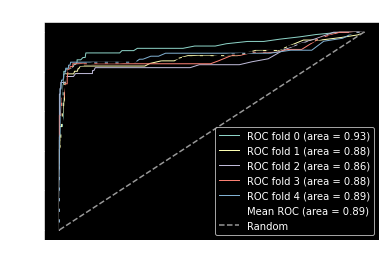

Random forests senstivity analysis Test Data:


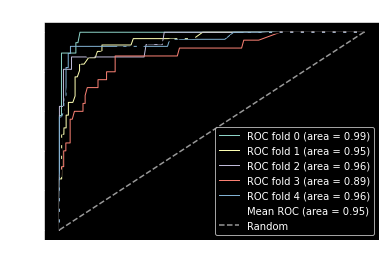

In [37]:
forest = CV_rfc.best_estimator_
forest_fit = forest.fit(X[train_index], y[train_index])
predictions = forest_fit.predict(X[test_index])

print(confusion_matrix(y[test_index], predictions))
print(accuracy_score(y[test_index], predictions))
print(classification_report(y[test_index], predictions))

print("Random forests senstivity analysis Train Data:")
plot_roc(X[train_index], y[train_index], CV_rfc.best_estimator_)
print("Random forests senstivity analysis Test Data:")
plot_roc(X[test_index], y[test_index], CV_rfc.best_estimator_)



~ Threshold Value ~


Text(0, 0.5, '%')

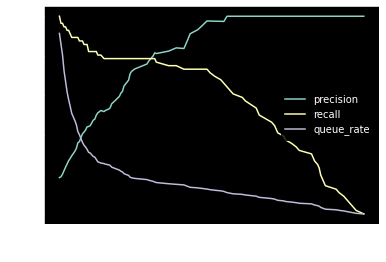

In [38]:
print("~ Threshold Value ~")
clf = CV_rfc.best_estimator_

n_trials = 50
test_size_percent = 0.1

signals = X
labels = y

plot_data = []

train_signals, test_signals, train_labels, test_labels = train_test_split(
    signals, labels, test_size=test_size_percent)
clf.fit(train_signals, train_labels)
predictions = clf.predict_proba(test_signals)[:, 1]

precision, recall, thresholds = precision_recall_curve(
    test_labels, predictions)
thresholds = np.append(thresholds, 1)

queue_rate = []
for threshold in thresholds:
    queue_rate.append((predictions >= threshold).mean())

plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')



In [39]:
clf = CV_rfc.best_estimator_

n_trials = 50
test_size_percent = 0.1

signals = X
labels = y

plot_data = []

for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
        signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:, 1]

    precision, recall, thresholds = precision_recall_curve(
        test_labels, predictions)
    thresholds = np.append(thresholds, 1)

    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())

    plot_data.append({
        'thresholds': thresholds,   'precision': precision,   'recall': recall,   'queue_rate': queue_rate
    })

Text(0.5, 0, 'threshold')

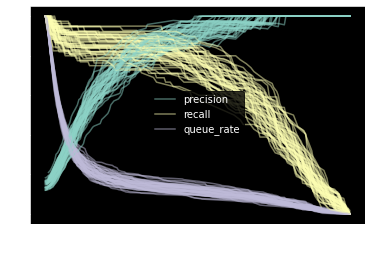

In [40]:
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'],
             color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'],
             color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'],
             color=sns.color_palette()[2], alpha=0.5)

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')



In [41]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []
uniform_recall_plots = []
uniform_queue_rate_plots = []

for p in plot_data:
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

Text(0, 0.5, '%')

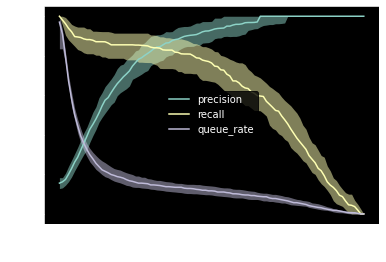

In [42]:
quantiles = [0.1, 0.5, 0.9]
lower_precision, median_precision, upper_precision = mstats.mquantiles(
    uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(
    uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(
    uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)
plt.plot(uniform_thresholds, median_recall)
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision,
                 alpha=0.5, linewidth=0, color=sns.color_palette()[0])
plt.fill_between(uniform_thresholds, upper_recall, lower_recall,
                 alpha=0.5, linewidth=0, color=sns.color_palette()[1])
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate,
                 alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')



Text(0, 0.5, '$')

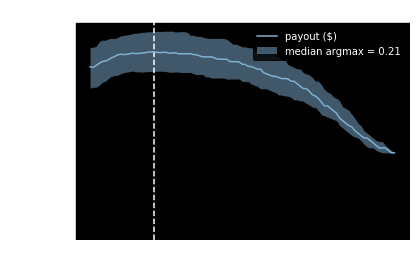

In [43]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000
success_payoff = 4
case_cost = 5

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]

        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(
    uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout,
                 alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]
plt.vlines([max_ap], -100000, 150000, linestyles='--')
plt.ylim(-100000, 150000)

leg = plt.legend(
    ('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('$')



In [44]:
print(np.max(median_payout))



116392.21556886226


In [45]:
# Scoring Model
def ChurnModel(df, clf):
    # Convert yes no columns to bool
    # yes_no_cols already known, stored as a global variable
    df[yes_no_cols] = df[yes_no_cols] == 'yes'
    # features already known, stored as a global variable
    X = df[features].to_numpy().astype(np.float)
    X = scaler.transform(X)

    """
    Calculates probability of churn and expected loss, 
    and gathers customer's contact info
    """
    # Collect customer meta data
    response = df[['Area Code', 'Phone']]
    charges = ['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']
    response['customer_worth'] = df[charges].sum(axis=1)

    # Make prediction
    churn_prob = clf.predict_proba(X)
    response['churn_prob'] = churn_prob[:, 1]

    # Calculate expected loss
    response['expected_loss'] = response['churn_prob'] * \
        response['customer_worth']
    response = response.sort_values('expected_loss', ascending=False)

    # Return response DataFrame
    return response



In [46]:
# Simulated new data
df = pd.read_csv("data/churn.csv")
train_index, test_index = train_test_split(df.index, random_state=4)
test_df = df.iloc[test_index]

# Apply new data to the model
ChurnModel(test_df, CV_rfc.best_estimator_)

,Area Code,Phone,customer_worth,churn_prob,expected_loss
3132,415,394-5489,87.35,0.995,86.913
289,510,352-6976,89.31,0.970,86.631
3205,408,345-3787,89.76,0.965,86.618
2113,408,335-2967,85.09,0.990,84.239
3272,510,373-7974,82.96,1.000,82.960
...,...,...,...,...,...
221,408,336-1090,56.82,0.000,0.000
2372,415,369-4012,57.43,0.000,0.000
3321,415,400-2738,53.20,0.000,0.000
3263,510,330-4364,50.27,0.000,0.000


In [47]:
InteractiveShell.ast_node_interactivity = "all"